# Curve Fitting Notebook

This notebook will analyze the data collected in the `BeamTracking` notebook.

### Theory

In the `CurveFitting` notebook, we collected data pertaining to the position of the beam center as a function of the rotation angle of the sample. 

From Nemoto (1992), we can model the displacement of the beam from the center (ie. where the beam would be if the sample wasn't there) as:

$$ \delta(\theta, n) = d \left( 1 - \frac{n_0 \cos(\theta)}{\sqrt{n^2 - n_0^2 \sin^2(\theta)}}\right)\sin(\theta) $$

Where $n$ is the (unknown) index of refraction of our material, $d$ is the (known) width of the material, and $n_0$ is the index of refraction of air. We can then fit this equation to find a value for $n$. Note that we actually fit 3 parameters:

$$ \delta(\theta, \vec a) = a_0 + d \left( 1 - \frac{n_0 \cos(\theta - a_1)}{\sqrt{a_2^2 - n_0^2 \sin^2(\theta - a_1)}}\right)\sin(\theta - a_1) $$

Where $a_0$ and $a_1$ are arbitrary parameters to account for the stage not being perfectly centered, and $a_2$ is the actual index of refraction that we want.

If for some reason you cannot measure the width of the sample, you can try fitting that as a parameter as well, though that will likely reduce the accuracy of the index of refraction by quite a bit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11

from scipy.optimize import curve_fit

import pandas as pd

The theoretical IOR here is just for sanity-check type of plotting below, and doesn't actually affect anything with the fitting below.

In [10]:
n0 = 1.00029 # Weisstein Eric. Index of Refraction. Wolfram Research. 2005.

# Path to the file that we will be reading data from
file = 'data/sapphire_disk_1014nm.txt'
#file = 'data/bk7_glass.txt'

# What we expect the IOR to be for sanity checks
theoreticalIOR = 1.760
#theoreticalIOR = 1.515

# The width of the sample in mm
d = 2.29 # for sapphire sample
#d = 5.59 # for bk7 glass slab
#w = .84 # Cuvette wall width
#d = 2*w # Empty cuvette
#d = 11.96 - 2*w # Oil cuvette

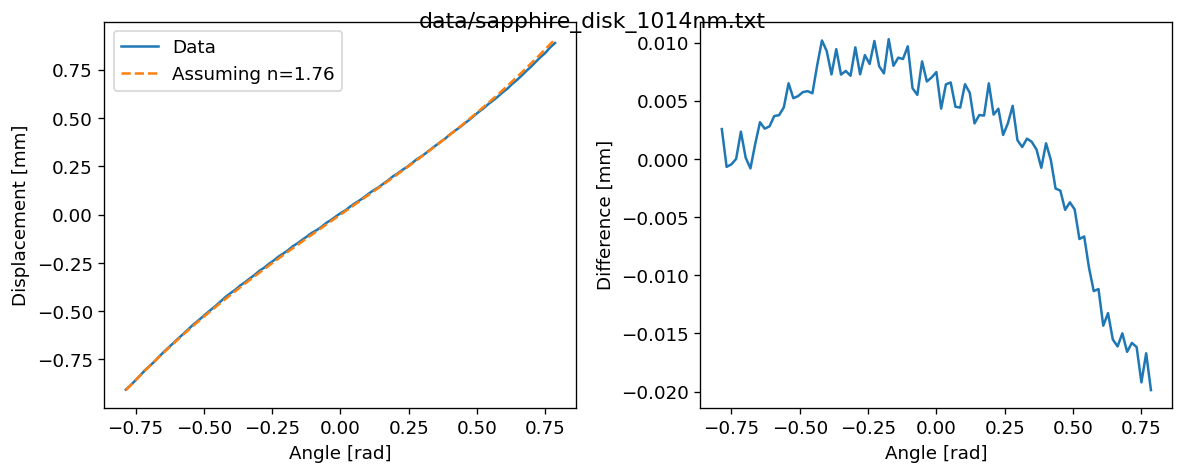

In [15]:
# Read the data file
data = pd.read_csv(file)

# Convert to radians and mm
# There may or may not have to be a negative here, not quite sure why
angleArr = -data["angle"] * np.pi / 180
displacementArr = data["gauss_center"] * 1e-3 - np.mean(data["gauss_center"] * 1e-3)

# In case you need to cut away some of the extreme data points because of issues
# with centering/interference
#angleArr = angleArr[len(angleArr)//2:]
#displacementArr = displacementArr[len(displacementArr)//2:]
angleArr = angleArr[5:-5]
displacementArr = displacementArr[5:-5]

# Functional form of the displacement as a function of angle,
# including extra parameters for phase and displacement offsets
# Theta should be in radians
def func_form(theta, a0, a1, a2):
    return a0 + d*np.sin(theta - a1)*(1 - (n0 * np.cos(theta - a1))/np.sqrt(a2**2 - n0**2 * np.sin(theta - a1)**2))

# Calculate what we might expect the curve to look like
testDisplacementArr = [func_form(t, 0, 0, theoreticalIOR) for t in angleArr]

# Plot everything
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(angleArr, displacementArr, label='Data')
ax[0].plot(angleArr, testDisplacementArr, '--', label=f'Assuming n={theoreticalIOR}')
ax[0].set_ylabel('Displacement [mm]')
ax[0].set_xlabel('Angle [rad]')
ax[0].legend()

ax[1].plot(angleArr, displacementArr - testDisplacementArr)
ax[1].set_xlabel('Angle [rad]')
ax[1].set_ylabel('Difference [mm]')
fig.suptitle(file)
fig.tight_layout()
#plt.savefig('images/sapphire_fit.png')
plt.show()

Here is where we actually do the fitting; if you suspect that the bounds for fitting below are not sufficient, be sure to change them. As of now, I can't imagine a material that wouldn't fall within these parameter values, but it is possible.

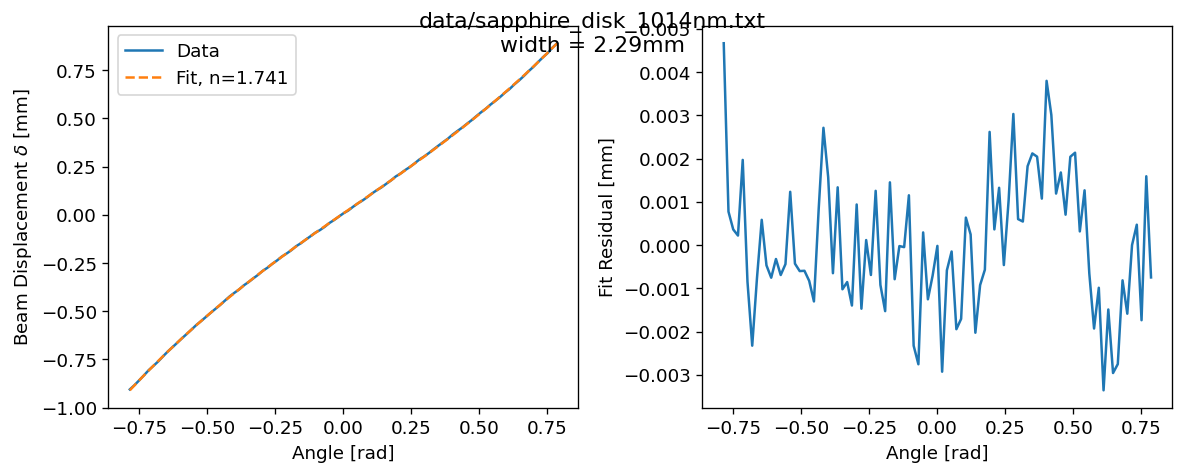

In [16]:
# Now actually do the curve fitting
popt, pcov = curve_fit(func_form, angleArr, displacementArr,
                       #method='trf',
                       # Bounds for [displacement offset, phase offset, IoR]
                       bounds=([-6, -np.pi/2 + .01, 1.2], # Lower bound
                               [6, np.pi/2 - .01, 1.9])) # Upper bound

# Make a pretty plot
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(angleArr, displacementArr, label='Data')
ax[0].plot(angleArr, func_form(angleArr, *popt), '--', label=f'Fit, n={popt[2]:.5}')
ax[0].set_xlabel('Angle [rad]')
ax[0].set_ylabel(r'Beam Displacement $\delta$ [mm]')
ax[0].legend()

ax[1].plot(angleArr, displacementArr - func_form(angleArr, *popt))
ax[1].set_xlabel('Angle [rad]')
ax[1].set_ylabel('Fit Residual [mm]')

fig.suptitle(f'{file}\nwidth = {d}mm')
fig.tight_layout()
#plt.savefig('images/sapphire_fit.png')
plt.show()

In [13]:
print(popt)

[-0.00557096 -0.00464651  1.76641584]
